# 2019-02-18 - Reverse correlation for V1 mapping
It would be fun to do it while i'm running the stims and waiting for mice anaesthesics to kick in

# Paper : http://www.jneurosci.org/content/26/12/3269#sec-2
# Step one : Create a lot of sub-arrays from the original image
# Step two : Gaussian window these sub-arrays
# Step three : fast fourier zero-pad these gaussian arrays
# Step four : reverse correlate for approx 50 ms
# Step five enjoy

# First things first, let's get the spikes from the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import KwikTools as kt

dataset = kt.load('../19NC0213/2019-02-13_13-19-24_A003/experiment1_100.raw.kwd',
                  'all')

info = dataset['info']['0']
data = dataset['data']['0']
channels = dataset['channel_bit_volts']['0']
timestamps = dataset['timestamps']['0']

data = np.asarray(data)
data = data.swapaxes(0, -1)
print('Data shape', data.shape)

Data shape (2, 58758600)


In [2]:
from scipy.signal import butter, lfilter


def filter_data(data, low, high, sf, order=2):
    # Determine Nyquist frequency
    nyq = sf/2

    # Set bands
    low = low/nyq
    high = high/nyq

    # Calculate coefficients
    b, a = butter(order, [low, high], btype='band')

    # Filter signal
    filtered_data = lfilter(b, a, data)

    return filtered_data

In [3]:
filtered_data = filter_data(data[0], low=300, high=6000, sf=30000)

In [4]:
def get_spikes(data, spike_window=80, tf=5, offset=10, max_thresh=350):
    '''
    Filtered data
    Number of points that will be extracted from signal
    Threshold factor, multiplied from signal mean
    Offset from the center for plotting afterwards
    Upper threshold, which eliminates artifacts
    '''
    # Calculate threshold based on data mean
    thresh = np.mean(np.abs(data)) * tf

    # Find positions wherere the threshold is crossed
    pos = np.where(data > thresh)[0]
    pos = pos[pos > spike_window]

    # Extract potential spikes and align them to the maximum
    spike_samp, spike_times = [], []
    wave_form = np.empty([1, spike_window*2])
    for i in pos:
        if i < data.shape[0] - (spike_window+1):
            # Data from position where threshold is crossed to end of window
            tmp_waveform = data[i:i+spike_window*2]

            # Check if data in window is below upper threshold (artifact rejection)
            if np.max(tmp_waveform) < max_thresh:
                # Find sample with maximum data point in window
                tmp_samp = np.argmax(tmp_waveform) + i

                # Re-center window on maximum sample and shift it by offset
                tmp_waveform = data[tmp_samp -
                                    (spike_window-offset):tmp_samp+(spike_window+offset)]

                # Append data
                spike_samp = np.append(spike_samp, tmp_samp)
                wave_form = np.append(
                    wave_form, tmp_waveform.reshape(1, spike_window*2), axis=0)
                spike_times = np.append(spike_times, i)

    # Remove duplicates
    ind = np.where(np.diff(spike_samp) > 1)[0]
    spike_samp = spike_samp[ind]
    wave_form = wave_form[ind]
    spike_times = spike_times[ind]

    return spike_samp, wave_form, spike_times

In [5]:
spike_samp, wave_form, spike_times = get_spikes(filtered_data, spike_window=50,
                                                tf=5, offset=20, max_thresh=400)

del_index = []
for it, waves in enumerate(wave_form):
    if np.NAN in waves or np.inf in waves or np.any(waves > 500) or np.any(waves< -500):
        print('Found NAN/inf/aberrant values at %s' % it)
        del_index.append(it)

wave_form = np.delete(wave_form, del_index, 0)
spike_times = np.delete(spike_times, del_index, 0)
spike_samp = np.delete(spike_samp, del_index, 0)

'''plt.figure(figsize=(15, 5))

for i in range(wave_form.shape[0]):
    plt.plot(wave_form[i, :])

plt.xlim([0, 90])
plt.ylim(-500, 500)
plt.title('Detected %s spikes for the whole signal' % wave_form.shape[0])
plt.show()'''

Found NAN/inf/aberrant values at 0
Found NAN/inf/aberrant values at 8
Found NAN/inf/aberrant values at 9
Found NAN/inf/aberrant values at 10
Found NAN/inf/aberrant values at 11
Found NAN/inf/aberrant values at 28
Found NAN/inf/aberrant values at 35
Found NAN/inf/aberrant values at 95
Found NAN/inf/aberrant values at 102
Found NAN/inf/aberrant values at 103
Found NAN/inf/aberrant values at 104
Found NAN/inf/aberrant values at 105
Found NAN/inf/aberrant values at 106
Found NAN/inf/aberrant values at 107
Found NAN/inf/aberrant values at 108
Found NAN/inf/aberrant values at 109
Found NAN/inf/aberrant values at 110
Found NAN/inf/aberrant values at 111
Found NAN/inf/aberrant values at 120
Found NAN/inf/aberrant values at 121
Found NAN/inf/aberrant values at 125
Found NAN/inf/aberrant values at 131
Found NAN/inf/aberrant values at 132
Found NAN/inf/aberrant values at 135
Found NAN/inf/aberrant values at 136
Found NAN/inf/aberrant values at 138
Found NAN/inf/aberrant values at 153
Found NAN/in

Found NAN/inf/aberrant values at 9785
Found NAN/inf/aberrant values at 9786
Found NAN/inf/aberrant values at 9803
Found NAN/inf/aberrant values at 9804
Found NAN/inf/aberrant values at 9822
Found NAN/inf/aberrant values at 9834
Found NAN/inf/aberrant values at 9835
Found NAN/inf/aberrant values at 9836
Found NAN/inf/aberrant values at 9837
Found NAN/inf/aberrant values at 9838
Found NAN/inf/aberrant values at 9839
Found NAN/inf/aberrant values at 9840
Found NAN/inf/aberrant values at 9841
Found NAN/inf/aberrant values at 9842
Found NAN/inf/aberrant values at 9843
Found NAN/inf/aberrant values at 9844
Found NAN/inf/aberrant values at 9845
Found NAN/inf/aberrant values at 9846
Found NAN/inf/aberrant values at 9865
Found NAN/inf/aberrant values at 9866
Found NAN/inf/aberrant values at 9867
Found NAN/inf/aberrant values at 9874
Found NAN/inf/aberrant values at 9875
Found NAN/inf/aberrant values at 9902
Found NAN/inf/aberrant values at 9903
Found NAN/inf/aberrant values at 9958
Found NAN/in

"plt.figure(figsize=(15, 5))\n\nfor i in range(wave_form.shape[0]):\n    plt.plot(wave_form[i, :])\n\nplt.xlim([0, 90])\nplt.ylim(-500, 500)\nplt.title('Detected %s spikes for the whole signal' % wave_form.shape[0])\nplt.show()"

In [6]:
# from sample dots to actual time points, as a way to align spike_times and chunk_list
spike_times = (spike_times/30000)+timestamps.min()

# Demo of the code used

In [7]:
import imageio
import os
from tqdm import tqdm

path_to_imgs = './sequences/RFMapping_psychopy_2019-02-13_13:19:19_A003/'
stim_arr = []

for imgs in tqdm(range(9000),' Importing stimuli'):
    stim_arr.append(imageio.imread(path_to_imgs+str(imgs)+'.png'))

 Importing stimuli: 100%|██████████| 9000/9000 [00:08<00:00, 1089.78it/s]


In [8]:
import numpy as np
import scipy.stats as st

def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel array."""

    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

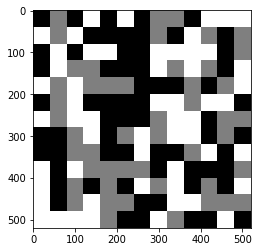

In [9]:
plt.imshow(stim_arr[0], cmap = plt.cm.gray)

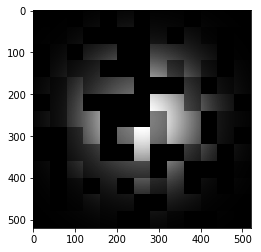

In [10]:
plt.imshow(gkern(520, nsig = 3.8)*stim_arr[0], cmap = plt.cm.gray)

We could for example use a  8x8 grid, as these make nice 64x64 subsets array

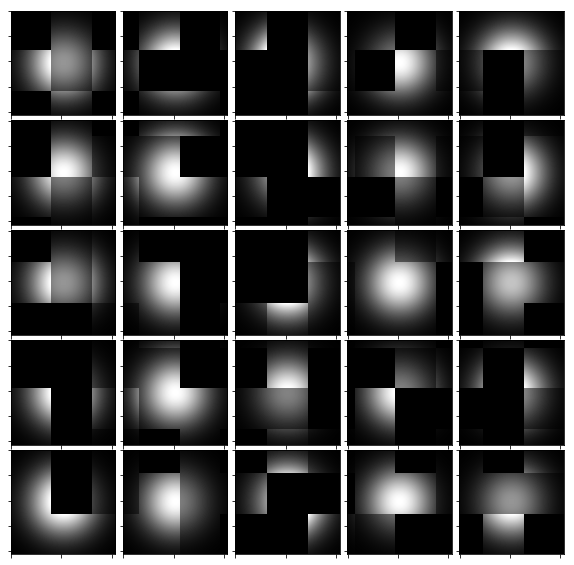

In [11]:
import matplotlib.gridspec as gridspec

im = stim_arr[0]
M = 104
N = 104
tiles = [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]

masked_tiles = []
for tile in tiles :
    masked_tiles.append(tile * gkern(M, nsig = 3.3))
    
tiles = masked_tiles

fig, ax = plt.subplots(5, 5, sharex='col', sharey='row', figsize = (10,10))
gs1 = gridspec.GridSpec(5, 5)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(25):
   # i = i + 1 # grid spec indexes from 0
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    ax1.imshow(tiles[i], cmap = plt.cm.gray)

plt.show()

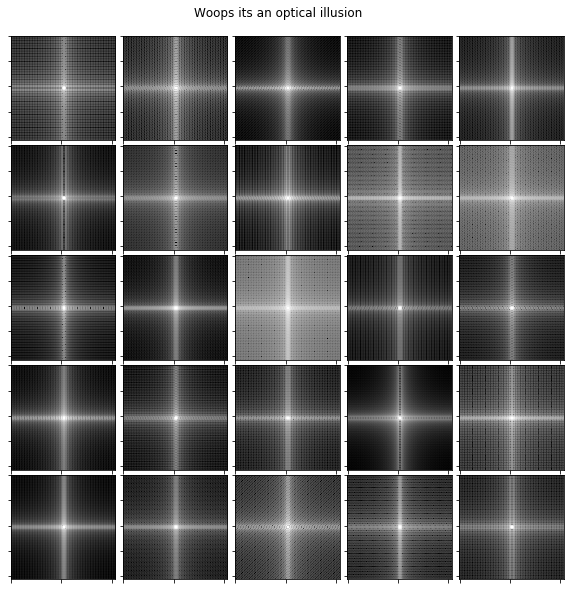

In [12]:
import matplotlib.gridspec as gridspec

im = stim_arr[0]
M = 104
N = 104
tiles = [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]

masked_tiles = []
for tile in tiles :
    masked_tiles.append(tile * gkern(M, nsig = 3.3))
    
tiles = masked_tiles

fig, ax = plt.subplots(5, 5, sharex='col', sharey='row', figsize = (10,10))
gs1 = gridspec.GridSpec(5, 5)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(25):
   # i = i + 1 # grid spec indexes from 0

    f = np.fft.fft2(tiles[i])
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))

    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    ax1.imshow(magnitude_spectrum, cmap = plt.cm.gray)

plt.suptitle(x = .5, y = .92, t = 'Woops its an optical illusion')
plt.show()

# Now we start reverse correlating the spikes with the spectrums

In [13]:
print('Mapping lasted %ss' % (timestamps.max() - timestamps.min()))
print('Meaning each stim was shown for %ss' % ((timestamps.max() - timestamps.min())/len(stim_arr)))

Mapping lasted 1958.6199666666662s
Meaning each stim was shown for 0.2176244407407407s


In [14]:
reverse_correlation_windows = [.1]#, .05, .1] #s =  ms
total_duration = timestamps.max() - timestamps.min()
avg_pres_time = total_duration/len(stim_arr)

all_evoking_imgs = []
for window in reverse_correlation_windows :
    images_evoking_spike = []
    for spike_time in tqdm(spike_times, 'Reverse correlating for window %s' % window) :
        evoking_img = ( spike_time - window - timestamps.min() ) / avg_pres_time
        images_evoking_spike.append(int(evoking_img))
    all_evoking_imgs.append(images_evoking_spike)

Reverse correlating for window 0.1: 100%|██████████| 8700/8700 [03:17<00:00, 43.94it/s]


# Adding the images, then Fourier

In [15]:
sum_imgs = []
for evoking_img in all_evoking_imgs[0]:
    sum_imgs.append(stim_arr[evoking_img])

sum_arr = np.sum(sum_imgs, axis = 0) / len(all_evoking_imgs[0])

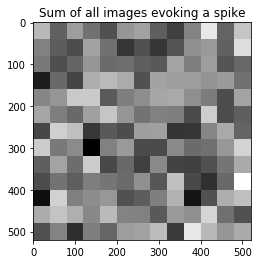

In [16]:
plt.title('Sum of all images evoking a spike')
plt.imshow(sum_arr, cmap = plt.cm.gray)

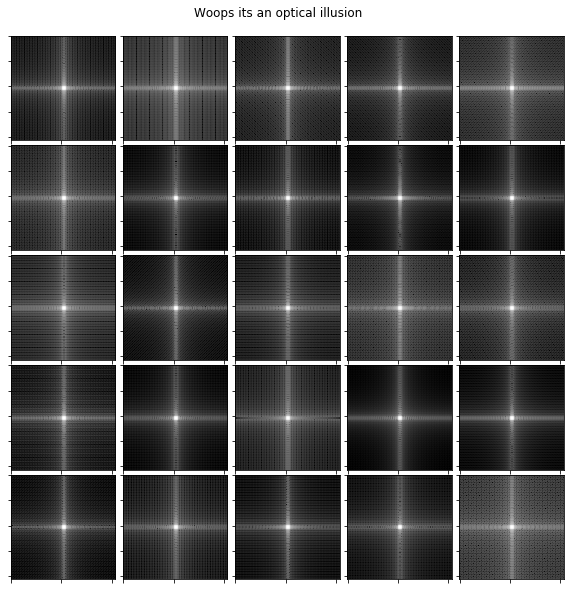

In [17]:
import matplotlib.gridspec as gridspec

im = sum_arr
M = 104
N = 104
tiles = [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]

masked_tiles = []
for tile in tiles :
    masked_tiles.append(tile * gkern(M, nsig = 3.3))
    
tiles = masked_tiles

fig, ax = plt.subplots(5, 5, sharex='col', sharey='row', figsize = (10,10))
gs1 = gridspec.GridSpec(5, 5)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(25):
   # i = i + 1 # grid spec indexes from 0

    f = np.fft.fft2(tiles[i])
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))

    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    ax1.imshow(magnitude_spectrum, cmap = plt.cm.gray)

plt.suptitle(x = .5, y = .92, t = 'Woops its an optical illusion')
plt.show()

# Fourier for each tile of each image

In [18]:
sum_imgs = []
for evoking_img in all_evoking_imgs[0]:
    sum_imgs.append(stim_arr[evoking_img])

M = 104
N = 104
gaussian_kernel = gkern(M, nsig = 3.3)

all_tiles = []
for x in range(0, im.shape[0], M):
    for y in range(0, im.shape[1], M):
        sub_tiles = []
        for evoking_img in tqdm(sum_imgs) :
            tile = im[x:x+M,y:y+N]
            masked_tile = tile * gaussian_kernel
            fourier_tile = np.fft.fft2(masked_tile) #todo, pytorch gpu FFT2 ?
            sub_tiles.append(fourier_tile)
        all_tiles.append(np.sum(sub_tiles, axis = 0))

100%|██████████| 8700/8700 [00:03<00:00, 2867.45it/s]


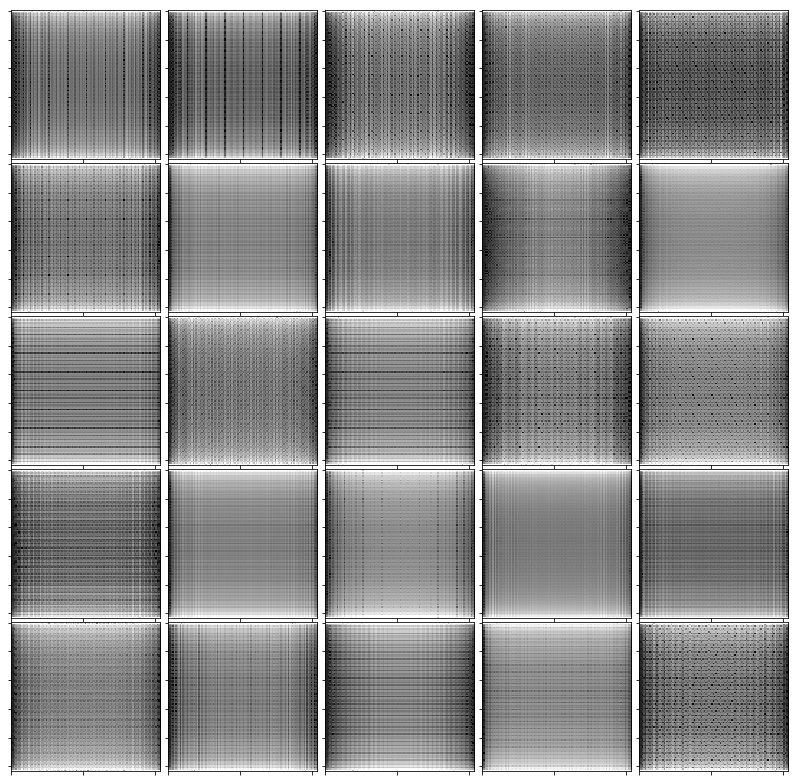

In [19]:
import matplotlib.gridspec as gridspec
from scipy import stats

fig, ax = plt.subplots(5, 5, sharex='col', sharey='row', figsize = (14,14))
gs1 = gridspec.GridSpec(5, 5)
gs1.update(wspace=0.025, hspace=0.025) # set the spacing between axes. 

for i in range(25):
   # i = i + 1 # grid spec indexes from 0

    ift = np.fft.ifft2(all_tiles[i])
    f = np.fft.fft2(ift)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.abs(fshift)

    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    
    toshow = np.log(abs(all_tiles[i]))
    toshow = stats.zscore(magnitude_spectrum)
    toshow = np.log(abs(stats.zscore(all_tiles[i])))
    
    im1 = ax1.imshow(toshow, cmap = plt.cm.gray, vmin = np.log(abs(stats.zscore(all_tiles))).min(),
                    vmax = np.log(abs(stats.zscore(all_tiles))).max())
plt.show()